In [1]:
%run Models.ipynb

# Fit with Nelder-Mead

In [2]:
mod = []

for i,c in enumerate(countries):
    mod.append(Model(c, SHIR, time=None, start=starts[i]))
    print('\n')

Creating SHIR for Italy
Loaded country's population
Loaded time series of 146 days
Lockdown at 2020-03-11 -> at day 49
first VA index with lockdown: 17


Creating SHIR for Germany
Loaded country's population
Loaded time series of 141 days
Lockdown at 2020-03-20 -> at day 58
first VA index with lockdown: 21


Creating SHIR for Spain
Loaded country's population
Loaded time series of 143 days
Lockdown at 2020-03-14 -> at day 52
first VA index with lockdown: 17


Creating SHIR for United Kingdom
Loaded country's population
Loaded time series of 139 days
Lockdown at 2020-03-23 -> at day 61
first VA index with lockdown: 22




In [3]:
beta = 1.
mu = 0.05
I0 = 2e-10
sigma = 0.05

init_params = [beta, mu, I0, sigma]

In [4]:
for m in mod:
    m.fit(init_params)

Start fitting
End fitting
Results:
 final_simplex: (array([[ 9.74299945e-01,  4.64445201e-05,  8.68827610e-06,
         2.29546322e-01],
       [ 9.74327984e-01, -4.57744894e-05,  8.68599584e-06,
         2.29549524e-01],
       [ 9.74256130e-01, -7.63787546e-06,  8.69341772e-06,
         2.29544408e-01],
       [ 9.74231330e-01,  7.81328854e-07,  8.69699689e-06,
         2.29542930e-01],
       [ 9.74225326e-01, -2.99854733e-05,  8.69638204e-06,
         2.29540991e-01]]), array([0.00415507, 0.00415507, 0.00415507, 0.00415507, 0.00415507]))
           fun: 0.004155065398920988
       message: 'Optimization terminated successfully.'
          nfev: 579
           nit: 345
        status: 0
       success: True
             x: array([9.74299945e-01, 4.64445201e-05, 8.68827610e-06, 2.29546322e-01])
Start fitting
End fitting
Results:
 final_simplex: (array([[ 1.07123818e+00,  6.09029682e-05,  1.45586872e-06,
         2.33499433e-01],
       [ 1.07131861e+00, -2.15223306e-05,  1.45445635e-

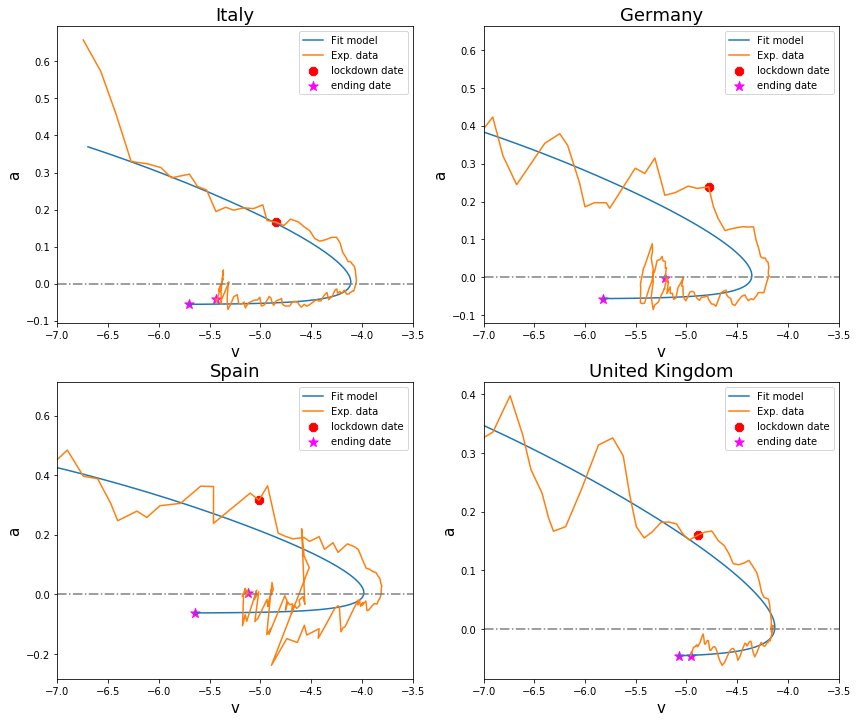

In [9]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    v, a = m.predict(m.optimal)
        
    plt.plot(v, a, label='Fit model')
    plt.scatter(v[-1], a[-1], 
                    c='magenta',marker='*',s=100,zorder=2)
    
    
    plt.plot(m.v_data, m.a_data, label='Exp. data')
    
    plt.scatter(m.v_data[m.lock_index-L-z], m.a_data[m.lock_index-L-z], 
                    c='red',marker='8',s=80, label='lockdown date')
    plt.scatter(m.v_data[-1], m.a_data[-1], 
                    c='magenta',marker='*',s=100,zorder=2, label='ending date')
    
    plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('v', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)

In [17]:
opt = []

for m in mod:
    opt.append(m.optimal)

opts = pd.DataFrame(opt, columns=['beta','mu','I0','sigma'], index=countries)
opts

,beta,mu,I0,sigma
Italy,0.949260,2.157093e-09,7.548614e-11,0.052692
Germany,1.147551,3.709172e-09,2.119554e-12,0.054522
Spain,1.475443,1.653611e-09,3.010252e-14,0.056051
United Kingdom,0.800820,1.139364e-09,8.069359e-11,0.044383


# Direct fit of acceleration

In [32]:
from scipy import optimize

In [27]:
cdict={'Germany':'#DDDD00',
       'Italy':'#11e0f0',
       'Spain':'red',
       'United Kingdom':'blue'}

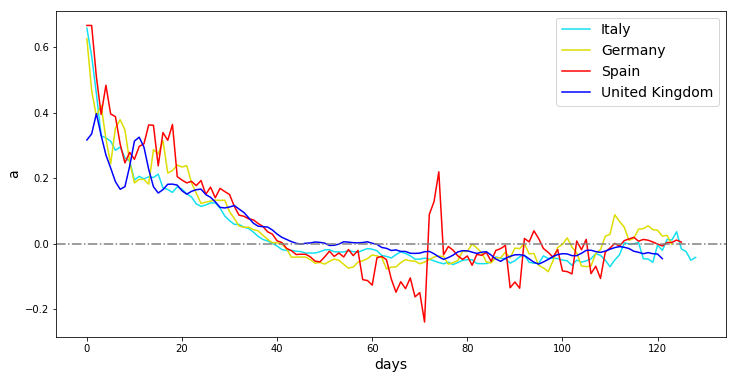

In [30]:
plt.figure(figsize=(12,6))

for i,m in enumerate(mod):
    plt.plot(range(m.T_va), m.a_data, c=cdict[countries[i]], label=countries[i])

plt.xlabel('days', size=14)
plt.ylabel('a', size=14)
plt.axhline(y=0, color='gray', linestyle='-.')
plt.legend(prop={'size': 14})
plt.show()

In [70]:
def func(t, b_eff, mu, sigma):
    return -(np.log(10)*sigma + mu) + b_eff * np.exp(-sigma*t)

In [71]:
fits = []

for i,m in enumerate(mod):
    bounds=([0.,0.,0.],[np.inf,np.inf,np.inf])
    params, params_covariance = optimize.curve_fit(func, np.arange(m.T_va), m.a_data, bounds=bounds)
    fits.append(params)
    print(params)

[5.12338065e-01 2.80518578e-16 3.69246422e-02]
[5.20018683e-01 3.42165684e-18 3.54704315e-02]
[6.25420709e-01 1.41522766e-14 3.78016308e-02]
[4.03057256e-01 1.12210504e-18 2.95801452e-02]


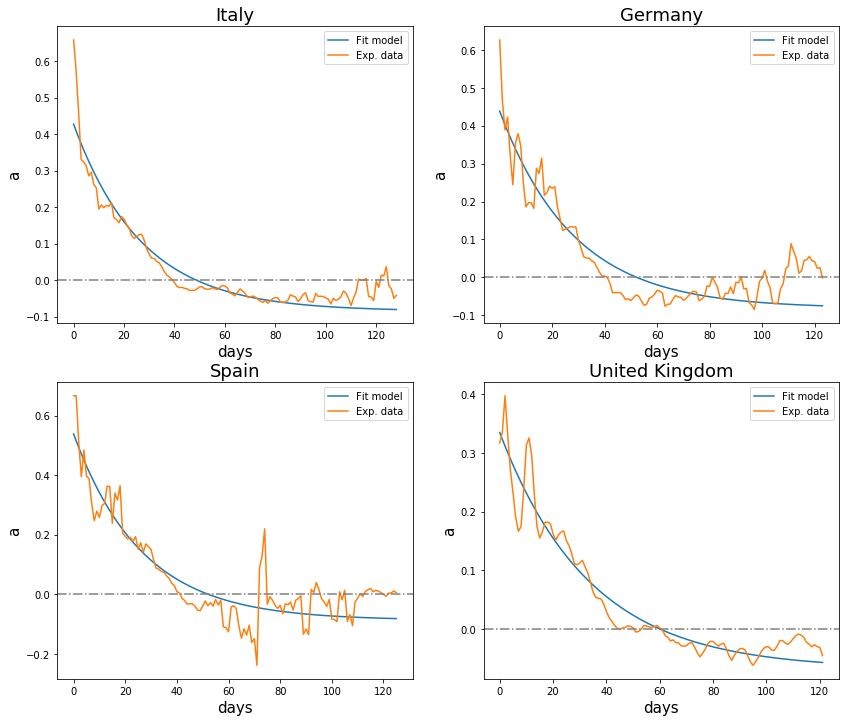

In [72]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    t = np.arange(m.T_va)
    plt.plot(t, func(t, fits[i][0], fits[i][1], fits[i][2]), label='Fit model')
    
    plt.plot(t, m.a_data, label='Exp. data')
    
    #plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('days', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)
    
plt.show()

In [73]:
opts1 = pd.DataFrame(fits, columns=['beta_eff', 'mu', 'sigma'], index=countries)
opts1

,beta_eff,mu,sigma
Italy,0.512338,2.805186e-16,0.036925
Germany,0.520019,3.421657e-18,0.035470
Spain,0.625421,1.415228e-14,0.037802
United Kingdom,0.403057,1.122105e-18,0.029580


# Fit only first 20 days

In [75]:
fits = []

for i,m in enumerate(mod):
    bounds=([0.,0.,0.],[np.inf,np.inf,np.inf])
    N = 20
    params, params_covariance = optimize.curve_fit(func, np.arange(N), m.a_data[:N], bounds=bounds)
    fits.append(params)
    print(params)

[6.4644822e-01 2.2990952e-13 5.4216070e-02]
[5.55236348e-01 6.49730898e-14 3.86475696e-02]
[6.39449198e-01 2.74405491e-14 3.80993472e-02]
[3.92361725e-01 6.07665697e-18 2.75042685e-02]


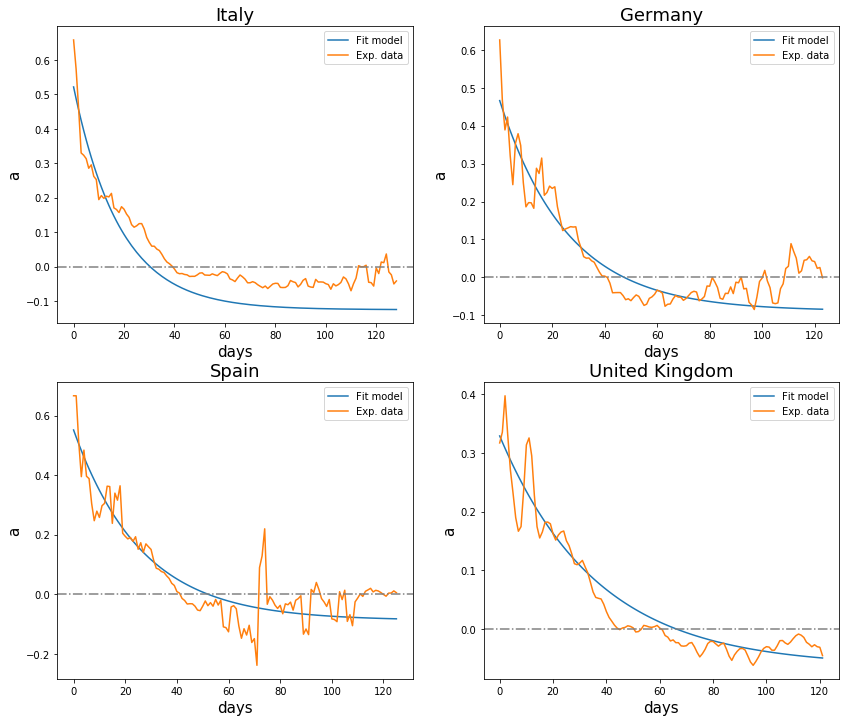

In [76]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    t = np.arange(m.T_va)
    plt.plot(t, func(t, fits[i][0], fits[i][1], fits[i][2]), label='Fit model')
    
    plt.plot(t, m.a_data, label='Exp. data')
    
    #plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('days', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)
    
plt.show()

In [77]:
opts2 = pd.DataFrame(fits, columns=['beta_eff', 'mu', 'sigma'], index=countries)
opts2

,beta_eff,mu,sigma
Italy,0.646448,2.299095e-13,0.054216
Germany,0.555236,6.497309e-14,0.038648
Spain,0.639449,2.744055e-14,0.038099
United Kingdom,0.392362,6.076657e-18,0.027504


# Comparison

In [78]:
pd.concat([opts['sigma'], opts1['sigma'], opts2['sigma']], axis=1, keys=['sigma Nelder-Mead', 'sigma direct', 'sigma direct 20'])

,sigma Nelder-Mead,sigma direct,sigma direct 20
Italy,0.052692,0.036925,0.054216
Germany,0.054522,0.035470,0.038648
Spain,0.056051,0.037802,0.038099
United Kingdom,0.044383,0.029580,0.027504


In [79]:
pd.concat([opts['mu'], opts1['mu'], opts2['mu']], axis=1, keys=['mu Nelder-Mead', 'mu direct', 'mu direct 20'])

,mu Nelder-Mead,mu direct,mu direct 20
Italy,2.157093e-09,2.805186e-16,2.299095e-13
Germany,3.709172e-09,3.421657e-18,6.497309e-14
Spain,1.653611e-09,1.415228e-14,2.744055e-14
United Kingdom,1.139364e-09,1.122105e-18,6.076657e-18
